## Random Acts Of Pizza
Even Oldridge - 3/5/2017

In [352]:
import json
import codecs
import pandas as pd
import numpy as np
from scipy import stats
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
from datetime import datetime

### Load the Data

In [2]:
path = './pizza_request_dataset/pizza_request_dataset.json'

In [28]:
ds = pd.read_json(path)

In [79]:
ds[:3]

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,requestdate_utc
0,N/A,False,2,6,0,t3_w5491,7,"I'm not in College, or a starving artist or an...","I'm not in College, or a starving artist or an...","[Request] Ontario, Canada - On my 3rd of 5 day...",...,AdviceAnimals WTF funny gaming movies technolo...,32,212,48,610,shroom,RitalinYourMemory,1341604684,1341601084,2012-07-06 11:58:04
1,N/A,False,2,6,1,t3_qysgy,8,Hello! It's been a hard 2 months with money an...,Hello! It's been a hard 2 months with money an...,"[REQUEST] Southern Arizona, Tucson Hungry Family",...,aww pics,5,21,13,57,shroom,blubirdhvn,1331868375,1331864775,2012-03-15 19:26:15
2,N/A,False,1,4,1,t3_if0ed,1,I'm sure there are needier people on this subr...,I'm sure there are needier people on this subr...,[Request] Pizza for a broke college student,...,AskReddit DoesAnybodyElse IAmA Marijuana Music...,1359,2110,2423,3456,shroom,taterpot,1309622289,1309618689,2011-07-02 07:58:09


First snag here; the requestor's subreddits are presented as a list.  For the type of analysis I want to do a string will work better.

In [43]:
requestorlist = []

In [45]:
for i in range (len(ds)):
    requestorlist.append(" ".join(ds.requester_subreddits_at_request[i])) 

In [50]:
requestorlist[:3]

['AdviceAnimals WTF funny gaming movies technology todayilearned videos',
 'aww pics',
 'AskReddit DoesAnybodyElse IAmA Marijuana Music Random_Acts_Of_Pizza WTF bestof2010 comics fffffffuuuuuuuuuuuu funny gaming happy listentothis nugs offbeat pics reddit.com relationship_advice seduction self todayilearned treecipes treecomics trees']

In [51]:
ds.requester_subreddits_at_request=requestorlist

Now we can run a profile on all of the variables since we have a regular pandas data frame:

In [53]:
pp.ProfileReport(ds)

Number of variables,33
Number of observations,5671
Total Missing (%),2.3%
Total size in memory,1.4 MiB
Average record size in memory,250.0 B
Numeric,23
Categorical,6
Date,0
Text (Unique),2
Rejected,2
Distinct count,332


Dates are also in unix format, so let's make them readable

In [76]:
requestdate = []
for i in range (len(ds)):
    requestdate.append(datetime.fromtimestamp(ds.unix_timestamp_of_request_utc[i])) 

In [78]:
ds['requestdate_utc']=requestdate

We'll likely want to parse this out to hours/month/years later when building a model but for now this should be good.

We also need to clean up the missing flair values

In [126]:
ds['requester_user_flair'] = ds.replace({'requester_user_flair':None},'NoFlair')['requester_user_flair']

Let's check up on our data again

In [127]:
pp.ProfileReport(ds)

Number of variables,34
Number of observations,5671
Total Missing (%),0.0%
Total size in memory,1.4 MiB
Average record size in memory,258.0 B
Numeric,23
Categorical,6
Date,1
Text (Unique),2
Rejected,2
Distinct count,332


Okay, data is in a good format now.  Let's take a look at what it contains:

Time to split the dataset into training and test

In [128]:
testset = ds[ds['in_test_set'] == True]
trainingset = ds[ds['in_test_set'] == False]

In [129]:
len(testset), len(trainingset)

(1631, 4040)

In [134]:
trainingset[:3]

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,requestdate_utc
0,N/A,False,2,6,0,t3_w5491,7,"I'm not in College, or a starving artist or an...","I'm not in College, or a starving artist or an...","[Request] Ontario, Canada - On my 3rd of 5 day...",...,AdviceAnimals WTF funny gaming movies technolo...,32,212,48,610,shroom,RitalinYourMemory,1341604684,1341601084,2012-07-06 11:58:04
1,N/A,False,2,6,1,t3_qysgy,8,Hello! It's been a hard 2 months with money an...,Hello! It's been a hard 2 months with money an...,"[REQUEST] Southern Arizona, Tucson Hungry Family",...,aww pics,5,21,13,57,shroom,blubirdhvn,1331868375,1331864775,2012-03-15 19:26:15
2,N/A,False,1,4,1,t3_if0ed,1,I'm sure there are needier people on this subr...,I'm sure there are needier people on this subr...,[Request] Pizza for a broke college student,...,AskReddit DoesAnybodyElse IAmA Marijuana Music...,1359,2110,2423,3456,shroom,taterpot,1309622289,1309618689,2011-07-02 07:58:09


### Inidividual variable exploration
My initial instinct is to dive into the text via LSA/LDA but it makes more sense to start with the numerical and categorical values and to see if there's any strong correlations there.

Looking at requester_user_flair revealed an important insight for model building that wasn't immediately obvious in the dataset; flair is only given to people who have received a pizza, so we need to make sure we throw that column away for training.

In [137]:
trainingset.groupby(['requester_received_pizza','requester_user_flair']).count()

giver_username_if_known  \
requester_received_pizza requester_user_flair                            
False                    NoFlair                                  3046   
True                     PIF                                        59   
                         shroom                                    935   

                                               in_test_set  \
requester_received_pizza requester_user_flair                
False                    NoFlair                      3046   
True                     PIF                            59   
                         shroom                        935   

                                               number_of_downvotes_of_request_at_retrieval  \
requester_received_pizza requester_user_flair                                                
False                    NoFlair                                                      3046   
True                     PIF                                                            59   
                         shroom                                                        935   

                                               number_of_upvotes_of_request_at_retrieval  \
requester_received_pizza requester_user_flair                                              
False                    NoFlair                                                    3046   
True                     PIF                                                          59   
                         shroom                                                      935   

                                               post_was_edited  request_id  \
requester_received_pizza requester_user_flair                                
False                    NoFlair                          3046        3046   
True                     PIF                                59          59   
                         shroom                            935         935   

                                               request_number_of_comments_at_retrieval  \
requester_received_pizza requester_user_flair                                            
False                    NoFlair                                                  3046   
True                     PIF                                                        59   
                         shroom                                                    935   

                                               request_text  \
requester_received_pizza requester_user_flair                 
False                    NoFlair                       3046   
True                     PIF                             59   
                         shroom                         935   

                                               request_text_edit_aware  \
requester_received_pizza requester_user_flair                            
False                    NoFlair                                  3046   
True                     PIF                                        59   
                         shroom                                    935   

                                               request_title       ...         \
requester_received_pizza requester_user_flair                      ...          
False                    NoFlair                        3046       ...          
True                     PIF                              59       ...          
                         shroom                          935       ...          

                                               requester_number_of_subreddits_at_request  \
requester_received_pizza requester_user_flair                                              
False                    NoFlair                                                    3046   
True                     PIF                                                          59   
                         shroom                                                      935   

                                     

That was the only categorical variable.  Let's look at some of the numerical variables and see how they correlate to successful pizza requests.

A quick and dirty way to do this is to look at their mean values.

In [140]:
trainingset.groupby(['requester_received_pizza']).mean()

,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_number_of_comments_at_retrieval,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,...,requester_number_of_posts_at_retrieval,requester_number_of_posts_on_raop_at_request,requester_number_of_posts_on_raop_at_retrieval,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,unix_timestamp_of_request,unix_timestamp_of_request_utc
requester_received_pizza,,,,,,,,,,,,,,,,,,,,,
False,False,2.378201,5.553513,9.052950e+07,2.090939,247.348502,734.690936,12.453199,499.212414,111.368352,...,38.920223,0.038083,1.080433,17.609324,1090.904465,2442.221930,3358.015430,6759.106369,1.344206e+09,1.344203e+09
True,False,2.566398,8.101610,1.314061e+08,5.261569,276.766844,828.179075,28.563757,579.609191,126.528169,...,47.989940,0.141851,1.725352,19.509054,1372.060362,3572.609658,4923.700201,10941.207243,1.338609e+09,1.338606e+09


We can also get more sophisticated and look at the point biserial correlations

In [659]:
biserial = []
for column in trainingset:
    if (trainingset[column].dtype == np.int64)|(trainingset[column].dtype == np.float64):
        correlation, pvalue = stats.pointbiserialr(trainingset['requester_received_pizza'],trainingset[column])
        #print(column + ' -- correlation=' +str(correlation)+', pvalue='+str(pvalue))
        biserial.append([column,correlation,pvalue])

In [660]:
biserial = sorted(biserial, key=lambda biserial: -biserial[1])
BS = pd.DataFrame(biserial)
BS

,0,1,2
0,requester_number_of_posts_on_raop_at_retrieval,0.460637,2.062371e-211
1,request_number_of_comments_at_retrieval,0.289153,1.195369e-78
2,requester_number_of_comments_in_raop_at_retrieval,0.274253,1.247359e-70
3,requester_number_of_posts_on_raop_at_request,0.137208,1.954994e-18
4,requester_number_of_comments_in_raop_at_request,0.131296,5.337936e-17
5,requester_days_since_first_post_on_raop_at_ret...,0.129283,1.591346e-16
6,requester_account_age_in_days_at_retrieval,0.120919,1.241585e-14
7,requester_number_of_comments_at_retrieval,0.105217,2.024969e-11
8,number_of_upvotes_of_request_at_retrieval,0.102138,7.666811e-11
9,requester_days_since_first_post_on_raop_at_req...,0.098225,3.938298e-10


A number of these numerical values are correlated with pizza, the strongest by far being the number of posts on RAoP at retreival.  It's worth noting that if the intention is to build a model that is able to "tell HS staff if their RAoP post will score a free pizza" here a lot of this data would be unusable since it was captured at retrieval time rather than request time and is inherently biased; getting a pizza clearly influences your behavior after the fact, with pizza receivers posting and commenting on RAoP much more frequently than non receivers.  Presumably this is to either thank the people who bought them the pizza or because they now feel like a part of the community and want to contribute.

In fact anything captured "at_retrieval" includes information that won't be known at test time, particularly since the delta between retrieval time and request time in this dataset is significant and varies by request.  request_number_of_comments_at_retrieval for example is our second most strongly correlated variable, which is very interesting because it implies that receiving a pizza on RAoP makes a user more active on reddit overall.  This finding may disappear when the brand new (0 day) accounts are removed from the set, but it's an interesting finding nonetheless.

Variables I would be comfortable including in a predictive model include:
- requester_account_age_in_days_at_request 
- requester_days_since_first_post_on_raop_at_request
- requester_number_of_comments_at_request
- requester_number_of_comments_in_raop_at_request
- requester_number_of_posts_at_request
- requester_number_of_posts_on_raop_at_request
- requester_number_of_subreddits_at_request
- requester_upvotes_minus_downvotes_at_request
- requester_upvotes_plus_downvotes_at_request 

Most of these are likely to be quite correlated, and we'll look into that below.

If we did want to include commenting and posting information, a better way of collecting this information would be to capture similar information at a  fixed time period (or even several time periods) after the request has been made.  Doing so would likely increase the accuracy of our model significantly.


In [251]:
modelCols = ['requester_account_age_in_days_at_request', 
'requester_days_since_first_post_on_raop_at_request',
'requester_number_of_comments_at_request',
'requester_number_of_comments_in_raop_at_request',
'requester_number_of_posts_at_request',
'requester_number_of_posts_on_raop_at_request',
'requester_number_of_subreddits_at_request',
'requester_upvotes_minus_downvotes_at_request',
'requester_upvotes_plus_downvotes_at_request' ]
extractedData = trainingset.filter(modelCols, axis = 1)

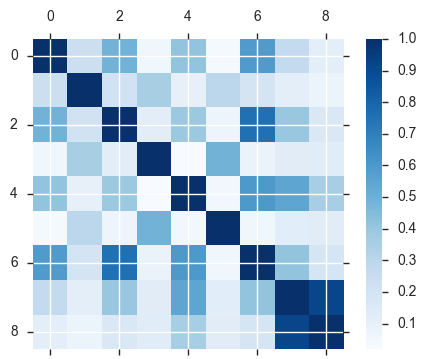

In [252]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(extractedData.corr(), cmap='Blues')
fig.colorbar(cax)

No surprise here; 0,2,4 & 6 are highly correlated, 1,3 & 5 are correlated, and 7 & 8 are almost identical.

The first group is the account age, number of comments, posts and subreddits.  The second is the days since first post, number of posts and number of comments on RAoP.  The third is the number of upvotes+downvotes and number of upvotes-downvotes.  It makes sense that these would be highly correlated.

Not much of a basis for a model, but we can try...

In [307]:
import xgboost as xgb

In [661]:
our_params = {'learning_rate': 0.1, 'seed':27, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'num_class':1, 'max_depth':3, 'min_child_weight':3} 
#d = {True: 1, False: 0}

target = pd.DataFrame(pd.to_numeric(trainingset['requester_received_pizza']), dtype='int')
#target.applymap(lambda x: d[x])


xgdmat = xgb.DMatrix(extractedData, label=target['requester_received_pizza'] )

In [571]:
len(extractedData),len(target['requester_received_pizza']), sum(target['requester_received_pizza'])

(4040, 4040, 994)

In [320]:
label = np.random.randint(2, size=5) # binary target
label[:5]

array([1, 1, 0, 1, 0])

In [662]:
cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 1000, nfold = 5,
                metrics = ['logloss', 'error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [663]:
cv_xgb.tail(10)

,test-error-mean,test-error-std,test-logloss-mean,test-logloss-std,train-error-mean,train-error-std,train-logloss-mean,train-logloss-std
24,0.240594,0.006895,0.541205,0.004186,0.233044,0.002335,0.524856,0.000974
25,0.239852,0.007605,0.541064,0.004597,0.232735,0.002990,0.524048,0.001012
26,0.239604,0.007693,0.540815,0.004547,0.232488,0.002920,0.523250,0.000985
27,0.240099,0.007343,0.540693,0.004891,0.232488,0.002659,0.522536,0.001024
28,0.240099,0.007788,0.540700,0.004923,0.232302,0.003040,0.521543,0.001237
29,0.240099,0.007788,0.540524,0.005002,0.232054,0.002662,0.520810,0.001175
30,0.240347,0.007565,0.540456,0.005156,0.232178,0.002337,0.519997,0.001403
31,0.240347,0.007565,0.540412,0.004960,0.231992,0.002440,0.519321,0.001389
32,0.240594,0.007368,0.540385,0.005135,0.231992,0.002584,0.518512,0.001363
33,0.240594,0.006895,0.540300,0.005266,0.231807,0.002525,0.517845,0.001404


Run on 5-fold cross validation our first model is surprisingly able to predict with a **76% accuracy** whether a requestor received a pizza or not, purely based on those 8 highly correlated features.

Let's build the model and take a look at the feature importance:

In [530]:
%%time
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 26)

Wall time: 39.1 ms


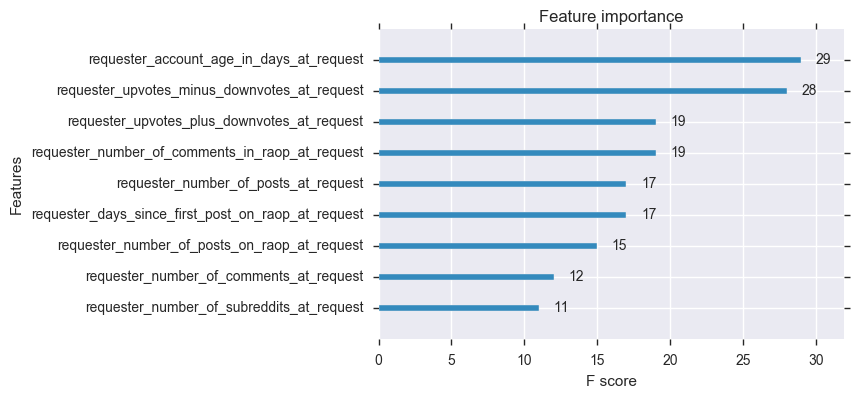

In [495]:
xgb.plot_importance(final_gb)

The two most important pieces are how long the user has been on reddit and their karma, which makes some sense intuitively.  Reddit users who have been a part of the community for a long time are more likely to receive help from that community.

So we have a basic model.  Can we improve upon it by adding information derived from the text?

## Analysis of the Text

It's time to dig into the text and see how we can improve the model by looking at what the user is posting.  We'll start with a Latent Semantic Analysis of the request text.

In [354]:
from gensim.corpora import TextCorpus, MmCorpus, Dictionary

In [401]:
x = trainingset['request_text_edit_aware']
y=[]
for i in range(len(x)):
    y.append(x[i])
ywords = [[i for i in y.lower().split()] for y in y]

In [405]:
dictionary = Dictionary(ywords)
dictionary.save('pizza.txtdic')

In [407]:
print(dictionary)

Dictionary(22645 unique tokens: ['second,', 'drafty', 'basic', 'services,', 'field']...)


In [421]:
corpus = [dictionary.doc2bow(text) for text in ywords]
MmCorpus.serialize('pizza.mm', corpus) 
#print(corpus)

In [414]:
lsi = gensim.models.LsiModel(corpus, num_topics=20)

In [446]:
tv = lsi[corpus]

In [447]:
tv[0]

[(0, 12.882255413549288),
 (1, 1.621525085946772),
 (2, -1.9172958422075974),
 (3, -2.4270703361486881),
 (4, -1.0316604801334144),
 (5, -1.0086599316375435),
 (6, 1.9982565408339352),
 (7, -1.9147856891393336),
 (8, -2.2752813737161408),
 (9, -2.3391391562334372),
 (10, 1.3141745631092876),
 (11, -2.2097627639941444),
 (12, 1.3811779971904301),
 (13, -0.66544043465055924),
 (14, 1.7069748402378231),
 (15, 1.5991543152762275),
 (16, 1.2206699671629089),
 (17, 0.84463788279409879),
 (18, -0.35573528758291617),
 (19, -2.4470177718779573)]

After playing around with Gensim for a while I decided to try the sklearn implementation instead because of the required data manipulation and how much time it was taking up...

In [337]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

In [338]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english',
                             use_idf=True)

In [339]:
train_tfidf = vectorizer.fit_transform(trainingset['request_text_edit_aware'])

In [341]:
print("  Actual number of tfidf features: %d" % train_tfidf.get_shape()[1])

  Actual number of tfidf features: 5766


In [548]:
svd = TruncatedSVD(20)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
train_lsa = lsa.fit_transform(train_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

  Explained variance of the SVD step: 7%


In [440]:
text_vectors=pd.DataFrame(train_lsa)

In [600]:
text_vectors[:5]

4040

In [443]:
mergedData = extractedData.join(text_vectors, lsuffix='_extractedData', rsuffix='_text_vectors')

In [458]:
mergedData[:5]

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,0,...,10,11,12,13,14,15,16,17,18,19
0,14.416875,0.000000,8,0,1,0,8,32,48,0.831622,...,-0.217539,0.043888,0.013044,-0.061206,-0.149538,0.054948,-0.058477,-0.022003,0.004596,0.001443
1,11.957060,0.000000,2,0,0,0,2,5,13,0.554701,...,0.048628,-0.067311,0.355154,0.037395,-0.052020,0.138948,0.164896,-0.067221,-0.134398,-0.430244
2,454.388461,22.915370,236,1,26,0,25,1359,2423,0.668210,...,-0.218353,0.226655,0.100279,0.179681,0.052080,-0.149161,-0.172971,-0.276159,0.022698,-0.201462
3,141.715625,17.156655,266,1,5,0,56,1205,2403,0.520470,...,-0.277234,0.183020,-0.030120,-0.042166,-0.038613,-0.184022,-0.057043,0.185739,-0.120645,0.011503
4,161.699155,0.000000,38,0,6,0,3,81,225,0.767047,...,-0.102261,0.166644,0.113481,-0.102192,0.207254,-0.040817,-0.184072,0.037020,0.306853,0.129809


In [533]:
xgdmat_text = xgb.DMatrix(mergedData, label=target['requester_received_pizza'] )

In [664]:
cv_xgb2 = xgb2.cv(params = our_params, dtrain = xgdmat_text, num_boost_round = 1000, nfold = 5,
                metrics = ['logloss', 'error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 500) # Look for early stopping that minimizes error

In [665]:
cv_xgb2.tail(10)

,test-error-mean,test-error-std,test-logloss-mean,test-logloss-std,train-error-mean,train-error-std,train-logloss-mean,train-logloss-std
36,0.241832,0.002548,0.530026,0.003413,0.226176,0.001553,0.486356,0.001381
37,0.240099,0.003321,0.529728,0.003122,0.225743,0.001713,0.485101,0.001157
38,0.240099,0.002071,0.529221,0.002507,0.225309,0.001164,0.483740,0.001085
39,0.239851,0.002268,0.529070,0.002607,0.224753,0.001597,0.482668,0.000928
40,0.239357,0.002158,0.528998,0.002778,0.224443,0.001419,0.481630,0.001195
41,0.240346,0.002400,0.529394,0.003201,0.224195,0.001690,0.480607,0.001181
42,0.239357,0.002779,0.529042,0.002855,0.223824,0.001419,0.479289,0.001182
43,0.240099,0.001750,0.529152,0.002854,0.223391,0.001438,0.477937,0.001242
44,0.241337,0.000783,0.529187,0.002730,0.222834,0.001732,0.476899,0.001299
45,0.241337,0.000783,0.528732,0.002631,0.222401,0.002174,0.475724,0.001281


Something strange is going on.  We added that text information and it wasn't able to find any improvement in the model.

Let's do an investigation:

In [667]:
%%time
final_gb2 = xgb.train(our_params, xgdmat_text, num_boost_round = 40)

Wall time: 73.1 ms


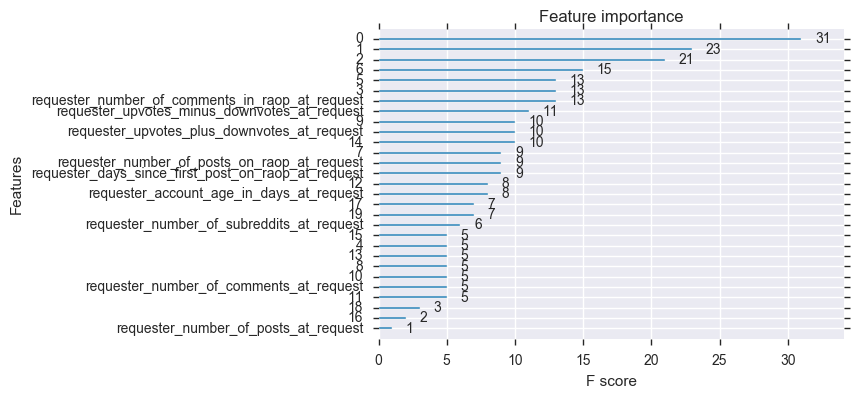

In [668]:
xgb.plot_importance(final_gb2)

It's looking at the text vector features and using them to predict.

Let's look at the confusion matrices and see what they look like

In [681]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [682]:
def prediction(pred):
    scaledBinPred = []
    for i in range(len(pred)):
        if pred[i] > 0.5:
            scaledBinPred.append(1)
        else: 
            scaledBinPred.append(0)
    return scaledBinPred

Let's first look at the original model without text...

[[3037    9]
 [ 933   61]]


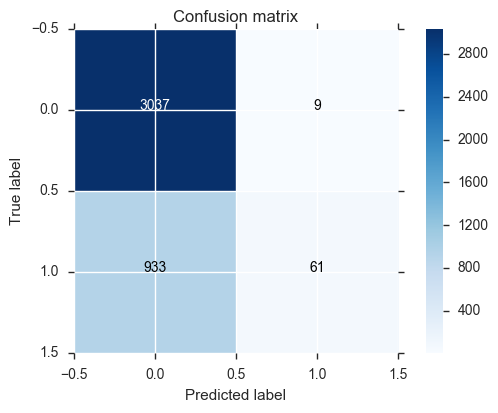

In [590]:

validationmat = xgb2.DMatrix(extractedData)
preds=final_gb.predict(validationmat)
cm = confusion_matrix(target['requester_received_pizza'] , prediction(preds.tolist()))
plot_confusion_matrix(cm)

So clearly our original model is not nearly as good as we'd hoped; it's done a great job on the negatives, predicting those with a 99.7% accuracy, but it's only 6.34% accurate on the positive examples.

With the addition of text vectors our new model's confusion matrix is:

[[3033   13]
 [ 905   89]]


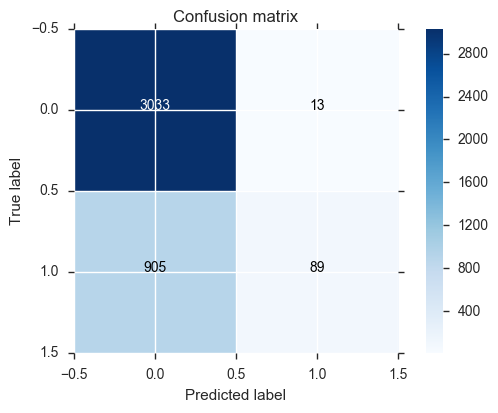

In [669]:
validationmat2 = xgb2.DMatrix(mergedData)
preds2=final_gb2.predict(validationmat2)
cm2 = confusion_matrix(target['requester_received_pizza'] , prediction(preds2.tolist()))
plot_confusion_matrix(cm2, )

So we have actually got significantly better at predicting the pizza receivers (8.94%)

We only used a 20 length vector which explained just 7% of the variance.  If we up the number of vectors significantly maybe we can see a bigger improvement.

In [553]:
svd2 = TruncatedSVD(400)
lsa2 = make_pipeline(svd2, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
train_lsa2 = lsa2.fit_transform(train_tfidf)

explained_variance2 = svd2.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance2 * 100)))

  Explained variance of the SVD step: 52%


In [554]:
text_vectors2=pd.DataFrame(train_lsa2)

In [555]:
mergedData2 = extractedData.join(text_vectors2, lsuffix='_extractedData', rsuffix='_text_vectors')

In [556]:
xgdmat_text2 = xgb.DMatrix(mergedData2, label=target['requester_received_pizza'] )

In [670]:
cv_xgb3 = xgb2.cv(params = our_params, dtrain = xgdmat_text2, num_boost_round = 1000, nfold = 5,
                metrics = ['logloss', 'error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 50) # Look for early stopping that minimizes error

In [671]:
cv_xgb3.tail(10)

,test-error-mean,test-error-std,test-logloss-mean,test-logloss-std,train-error-mean,train-error-std,train-logloss-mean,train-logloss-std
43,0.243069,0.003960,0.534785,0.003081,0.214356,0.001901,0.440280,0.002201
44,0.242574,0.003754,0.534672,0.003407,0.213800,0.001451,0.438678,0.001974
45,0.242327,0.004524,0.534168,0.003571,0.212809,0.001699,0.436593,0.002104
46,0.243565,0.004913,0.533854,0.003991,0.211758,0.002219,0.434755,0.002291
47,0.244554,0.004537,0.534241,0.003581,0.210582,0.002541,0.432717,0.002374
48,0.244802,0.004524,0.534240,0.003642,0.209777,0.002089,0.430821,0.002255
49,0.244307,0.004330,0.534744,0.003540,0.209097,0.002285,0.428799,0.002416
50,0.243317,0.003553,0.534575,0.003607,0.207426,0.003159,0.426795,0.002567
51,0.242574,0.004950,0.534336,0.003638,0.206807,0.003116,0.424958,0.002627
52,0.242327,0.003621,0.533747,0.003220,0.204765,0.003380,0.422825,0.002655


Looks like we weren't able to improve the model that much, but let's take a look just to be sure.

In [675]:
final_gb3 = xgb.train(our_params, xgdmat_text2, num_boost_round = 47)

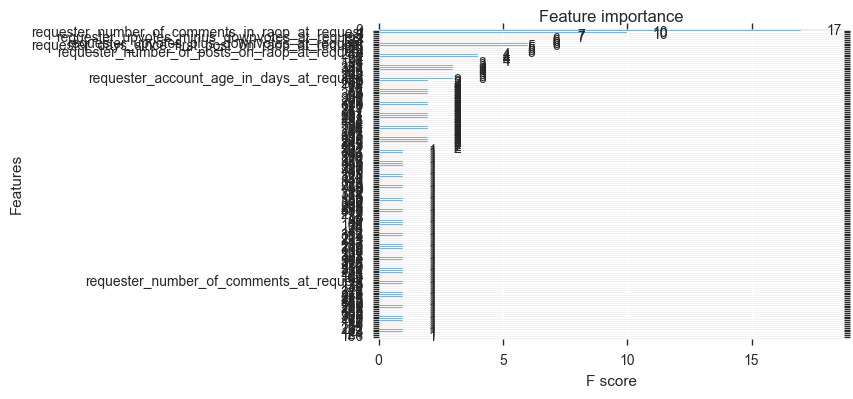

In [676]:
xgb.plot_importance(final_gb3)

[[3044    2]
 [ 868  126]]


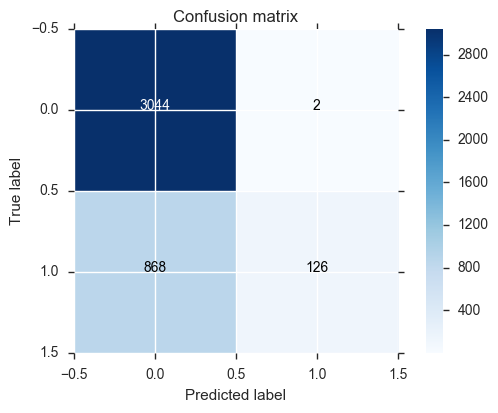

In [677]:
validationmat3 = xgb.DMatrix(mergedData2)
preds3=final_gb3.predict(validationmat3)
cm3 = confusion_matrix(target['requester_received_pizza'] , prediction(preds3.tolist()))
plot_confusion_matrix(cm3, )

We're able to improve our true positive set to 12.475%, which is an improvement of over 2x our initial model without text, but something still isn't right.  

At this point I decided to see how sensive xgboost is to our class imbalance.  I wouldn't call this a severely imbalanced set, but it's certainly imbalanced enough with 3 negative examples for every positive example.  

It turns out xgboost has an option in the parameters to specifically deal with class imbalance called scale_pos_weight.  If we set it to num(negative_examples)/num(posative_examples) then it should have an easier time finding a balanced model.

Let's update our parameters:

In [678]:
our_params = {'learning_rate': 0.1, 'seed':27, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'num_class':1, 'max_depth':3, 'min_child_weight':3,
             'scale_pos_weight':3.064386} 

In [679]:
cv_xgb3 = xgb2.cv(params = our_params, dtrain = xgdmat_text2, num_boost_round = 1000, nfold = 5,
                metrics = ['logloss', 'error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 50) # Look for early stopping that minimizes error

In [680]:
cv_xgb3.tail(10)

,test-error-mean,test-error-std,test-logloss-mean,test-logloss-std,train-error-mean,train-error-std,train-logloss-mean,train-logloss-std
321,0.290842,0.008021,0.586506,0.011789,0.008292,0.001911,0.198332,0.002054
322,0.290594,0.009308,0.586361,0.011784,0.008478,0.001862,0.197455,0.002016
323,0.290594,0.007959,0.586111,0.011859,0.008230,0.001644,0.196887,0.001987
324,0.290594,0.008036,0.586013,0.012037,0.008230,0.001485,0.196329,0.002049
325,0.290594,0.006614,0.585732,0.012138,0.008540,0.001667,0.195884,0.001999
326,0.290347,0.008005,0.585701,0.012211,0.008416,0.001618,0.195177,0.002105
327,0.291584,0.009182,0.585608,0.012309,0.008478,0.001523,0.194567,0.001876
328,0.288614,0.008445,0.585537,0.012225,0.008292,0.001430,0.193852,0.001751
329,0.289356,0.006975,0.585409,0.012231,0.008230,0.001392,0.193125,0.001756
330,0.290099,0.005784,0.585307,0.012443,0.008230,0.001350,0.192509,0.001778


This time we trained for a lot longer.  Hopefully our model is a little better.

In [596]:
final_gb3 = xgb.train(our_params, xgdmat_text2, num_boost_round = 328)

[[2993   53]
 [  12  982]]


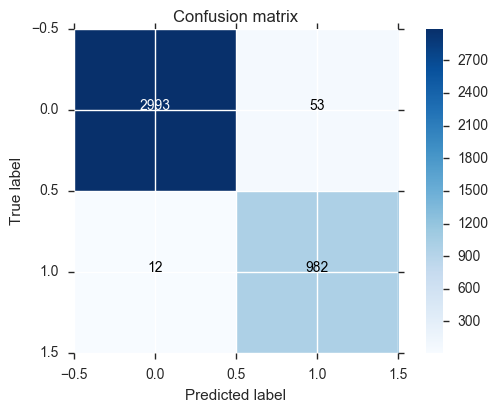

In [597]:
validationmat3 = xgb.DMatrix(mergedData2)
preds3=final_gb3.predict(validationmat3)
cm3 = confusion_matrix(target['requester_received_pizza'] , prediction(preds3.tolist()))
plot_confusion_matrix(cm3, )

And we're in business!  :-)

**98.4% accuracy** on the training set

While we're not at 99.9% we've developed a strong model for predicting whether or not a submission to ROAP is successful.  

Let's see how it performs on the test set.

In [629]:
test_extractedData = testset.filter(modelCols, axis = 1)
test_extractedData.reset_index(drop=True, inplace=True)

In [633]:
test_tfidf = vectorizer.transform(testset['request_text_edit_aware'])
test_lsa = lsa2.transform(test_tfidf)
test_text_vectors=pd.DataFrame(test_lsa)

In [639]:
test_merged = test_extractedData.join(test_text_vectors, lsuffix='_test_extractedData', rsuffix='_test_text_vectors')

In [635]:
test_target = pd.DataFrame(pd.to_numeric(testset['requester_received_pizza']), dtype='int')
test_target.reset_index(drop=True, inplace=True)

[[944 284]
 [244 159]]


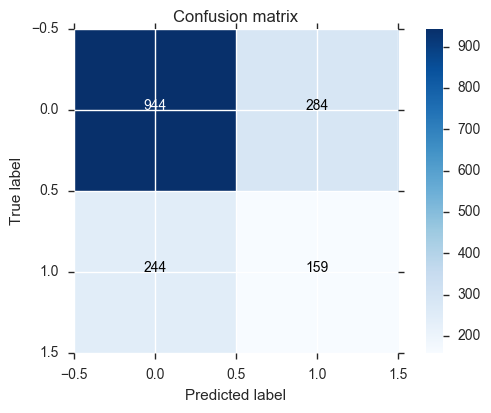

In [638]:
testmat = xgb.DMatrix(test_merged)
testpreds=final_gb3.predict(testmat)
testcm = confusion_matrix(test_target['requester_received_pizza'] , prediction(testpreds.tolist()))
plot_confusion_matrix(testcm, )

Definitely not as good as we might have hoped on the test set (67.6%), so there's clearly some overfitting going on.  We'd probably be better to scale back the number of text columns
.

Going back to our previous model with a length 20 vector:

In [641]:
test_lsa = lsa.transform(test_tfidf)
test_text_vectors=pd.DataFrame(test_lsa)

In [642]:
test_merged = test_extractedData.join(test_text_vectors, lsuffix='_test_extractedData', rsuffix='_test_text_vectors')

[[869 359]
 [215 188]]


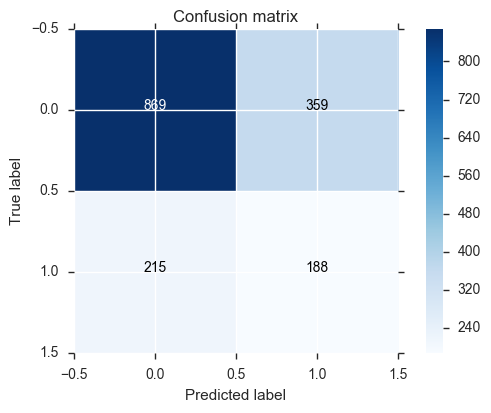

In [643]:
testmat = xgb.DMatrix(test_merged)
testpreds=final_gb2.predict(testmat)
testcm = confusion_matrix(test_target['requester_received_pizza'] , prediction(testpreds.tolist()))
plot_confusion_matrix(testcm, )

We can see that it does generalize better on the positive cases and it's only slightly less accurate.

Our model is **64.8%** accurate on the test set although it's only 46.7% accurate for positive examples.

It's quite likely that with more training data (5K is a very small dataset, particularly for something as nuanced as text) we would be able to significantly improve the model's performance on new examples.

Other options for improving the model's performance include:
 - Using averaged word2vec vectors as our text representation rather than LSA
 - Bayesian or SVM based classification
 - Training a neural network on the text vectors
 - Adding text vector representations of:
     - the title of the request (or just appending it to the text)
     - subreddits the user belongs to

 
The final project I was interested in doing but didn't have time to explore was an RNN to generate text that's likely to get you a pizza.  Teaching a neural network to ask for free pizza 

### Thanks!

This has been a really interesting dive into a dataset I wouldn't have otherwise explored and it's certainly one of the more interesting interviews I've done.

Thank you for your consideration and I look forward to hearing from you soon.

In [696]:
trainingset['requester_received_pizza'][9]

True

In [699]:
file = open("successful.txt",'w')
for i in range(len(x)):
    if trainingset['requester_received_pizza'][i] == True:
        file.write(trainingset['request_text_edit_aware'][i])
file.close()